In [1]:
# imports
from IPython import display
from sklearn.datasets import make_blobs
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances
import random
import itertools
import math

# FPT Approximations for Unfair k-Min-Sum-Radii

#### Creating example data

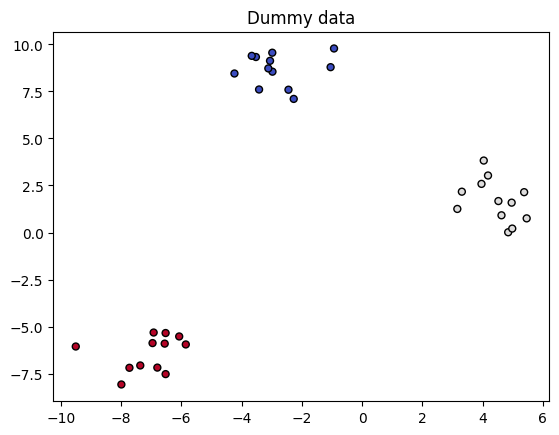

In [2]:
# generate dummy data
k = 3
points, cluster_membership = make_blobs(
    n_samples=36,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


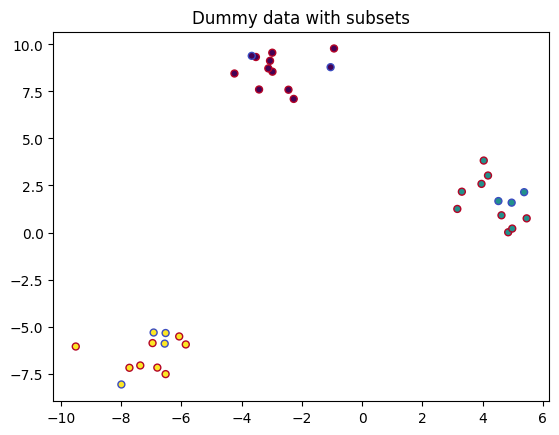

In [3]:
# choosing points to represent two subsets in 1:3 ratio:
subset_membership = np.array([10 if index % 4 == 0 else 200 for index in range(len(points))])


cmap=plt.cm.coolwarm
norm = mcolors.Normalize(vmin=min(subset_membership), vmax=max(subset_membership))
edge_colors = cmap(norm(subset_membership))
plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=edge_colors)
plt.show()

# The Algorithm

## 1. Constructing unfair clusters that contain the optimal solution
Necessary subroutines: guessing centers -> k-completion -> Gonzalez, guessing radii 

In [4]:
# distance function
pairwise_dist = DistanceMetric.get_metric('euclidean')

To better understand the following k_completion implementation, it is helpful to first remember the basics of farthest-first traversal implemented in Gonzalez. This algorithm already achieves a 2-approximation for unfair clustering, which leads to remarkably accurate centers, even if you start with a randomly selected one.

In [5]:
def gonzalez(points, k):
    points = np.array(points)
    n = len(points)
    centers = []

    start_idx = np.random.choice(n)
    centers.append(points[start_idx])
    
    if(k==1):
        return centers

    while(len(centers) < k):
        dists = np.min(pairwise_dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return np.array(centers)
print("Example:")
print(gonzalez(points, 5))

Example:
[[-6.95163731 -5.8765767 ]
 [-0.92998481  9.78172086]
 [ 4.84874243  0.01349956]
 [ 4.03817222  3.82544787]
 [-4.23411546  8.4519986 ]]


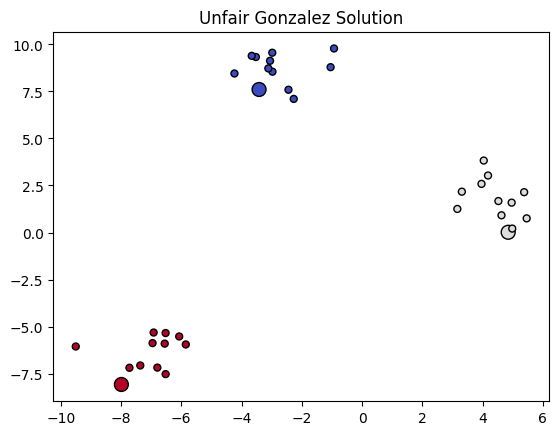

In [6]:
# centers are enlarged
gonzalez_solution = gonzalez(points, k)
plt.title("Unfair Gonzalez Solution")
sizes = [100 if tuple(point) in map(tuple, gonzalez_solution) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

#### Modified distance function
However, this approach might fail for overlapping clusters as described in the paper (figure 2). Due to this, we first want to guess a radius profile that we can then fit to guessed centers, using a modified distance function.//
This specific approach using numpy arrays only works for 2D data. Since the algorithm is very slow as is, and 2D data is most easily visualized, this will be good enough for now.

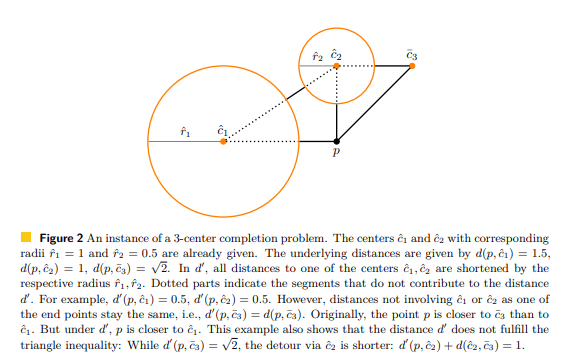

In [7]:
display.Image("img/figure2.png")

In [8]:
def get_radius(point, centers, radii):
        idx = np.where(np.all(centers == point, axis=1))[0] # this specifically only works for 2D data
        return radii[idx[0]] if len(idx) > 0 else 0

def dist_m(point_a, point_b, centers, radii):
    default_distance = euclidean(point_a, point_b)
    a_is_center = any(np.array_equal(point_a, center) for center in centers)
    b_is_center = any(np.array_equal(point_b, center) for center in centers)

    if a_is_center and b_is_center:
        return max(default_distance - get_radius(point_a, centers, radii) - get_radius(point_b, centers, radii), 0)
    elif a_is_center:
        return max(default_distance - get_radius(point_a, centers, radii), 0)
    elif b_is_center:
        return max(default_distance - get_radius(point_b, centers, radii), 0)
    else:
        return default_distance

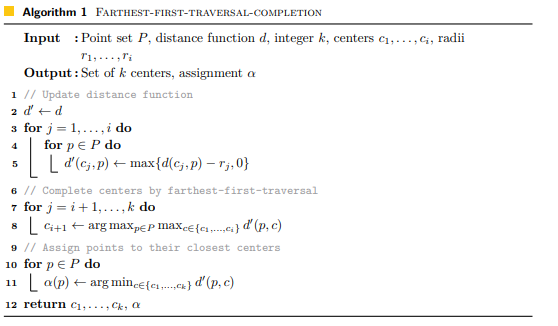

In [9]:
display.Image("img/algorithm1.png")

In [10]:
# algorithm 1 using the modified distance function
def k_completion(points, centers, radii, k):

    if(k==len(centers)):
        return centers
    
    if(len(centers)==0):
        centers.append(points[np.random.choice(len(points))])

    while(len(centers) < k):
        dists = np.min(pairwise_distances(points, metric=dist_m, centers=np.array(centers), radii=radii), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return centers

#### Guessing radii
For ease of implementation, we assume epsilon to be 0.5.\
We also need an Approximation for a k center solution, for which we will use Gonzalez algorithm, which has an approximation factor of 2 (https://www.sciencedirect.com/science/article/pii/0304397585902245?via%3Dihub)

In [11]:
# this allows for tuples like [1, 1, 1, 1], that can lead to the same center being picked twice
def get_assignment_tuples(n, k):
    return list(itertools.combinations(range(n), k))

In [12]:
def get_radii(points, centers):

    radii = []
    assigned_points = defaultdict(list)

    for point in points:
        distances = np.linalg.norm(centers - point, axis=1)
        nearest_center_idx = np.argmin(distances)
        assigned_points[nearest_center_idx].append(point)

    for idx, center in enumerate(centers):
        if assigned_points[idx]:
            assigned = np.array(assigned_points[idx])
            max_dist = np.max(np.linalg.norm(assigned - center, axis=1))
        else:
            max_dist = 0 # catch empty clusters with only the center
        radii.append(max_dist)

    return radii

def guessing_radii(points, k):

    possible_radii_profiles = []

    # first we need to guess the largest radius, to decrease our guessing interval from there
    # for that we need an estimated k center solution as upper bound

    k_center = gonzalez(points, k) # 2 approximation

    epsilon = 0.4 # use lower epsilon for more (anbd more precise), but slower results
    k_center_radii = get_radii(points, k_center)
    max_radius = max(k_center_radii)
    beta = 2
    j = 1

    # each profile is initialized with a sub interval of the largest possible solution, which would be one large radius aka the max k center radius times k
    possible_radii_profiles.append([pow(1 + epsilon, j - 1) * (max_radius / beta)]) # lower bound
    while (j < math.log(beta * k, 1+epsilon) and possible_radii_profiles[-1] < max_radius * k): # both conditions should mean the same
        possible_radii_profiles.append([pow(1+epsilon, j) * (max_radius/beta)]) # if the actual radius is between this and the previous iteration, this one is at most 1+epsilon times worse
        j += 1
    possible_radii_profiles.append([max_radius * k]) # upper bound

    # each profile is then appended with its own possible sub intervals (then the largest radius is put at the end)
    
    for profile in possible_radii_profiles:
        j = 2
        lower_bound = epsilon/k * profile[0]
        while (j <= math.log(k/epsilon, 1+epsilon) and profile[-1] <= profile[0]):
            profile.append(pow(1+epsilon, j) * lower_bound)
            j += 1
        # put largest radius of the interval at the end to have the profile sorted
        profile.append(profile[0])
        profile.pop(0)

    return possible_radii_profiles


# as can be observed, this algorithm does not have to produce k radii per profile. however later on, only the up to k radii that minimize the objective function will be selected
solution = guessing_radii([[1,1], [1,2], [1,3], [1,4], [2,1], [2,2], [2,3], [2,4]], 4)
for profile in solution:
     print(profile)

[np.float64(0.09799999999999999), np.float64(0.13719999999999996), np.float64(0.19207999999999997), np.float64(0.26891199999999993), np.float64(0.3764767999999999), np.float64(0.5)]
[np.float64(0.13719999999999996), np.float64(0.19207999999999995), np.float64(0.26891199999999993), np.float64(0.37647679999999983), np.float64(0.5270675199999998), np.float64(0.7)]
[np.float64(0.19207999999999995), np.float64(0.26891199999999993), np.float64(0.3764767999999999), np.float64(0.5270675199999998), np.float64(0.7378945279999997), np.float64(0.9799999999999999)]
[np.float64(0.2689119999999999), np.float64(0.3764767999999998), np.float64(0.5270675199999998), np.float64(0.7378945279999995), np.float64(1.0330523391999993), np.float64(1.3719999999999997)]
[np.float64(0.3764767999999999), np.float64(0.5270675199999998), np.float64(0.7378945279999998), np.float64(1.0330523391999995), np.float64(1.4462732748799993), np.float64(1.9207999999999996)]
[np.float64(0.5270675199999998), np.float64(0.737894527

#### First step algorithm
Described as Algorithm 2 in the paper, this is the main part of the computation for the unfair approximation

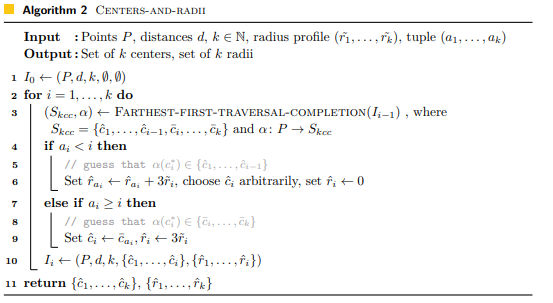

In [13]:
display.Image("img/algorithm2.png")

In [14]:
def algorithm_2(points, k, radii, assignment_tuple):
    radii = [radii[i] for i in assignment_tuple] # because the guessed profile can (and almost always will) contain more than k radii 
    assignment_tuple = [i for i in range(k)]

    guessed_centers = k_completion(points=points, centers=[], radii=radii, k=k)
    for i in range(k):
        temp_centers = k_completion(points=points, centers=guessed_centers[:i], radii=radii, k=k)
        if(assignment_tuple[i]<i):
            radii[assignment_tuple[i]] += 3 * radii[i]
            radii[i] == 0
            temp_centers[i] == random.choice(points)
        elif(assignment_tuple[i] >= i):
            temp_centers[i] = temp_centers[assignment_tuple[i]]
            radii[i] = 3 * radii[i]
        guessed_centers = k_completion(points=points, centers=temp_centers[:i+1], radii=radii, k=k)
    return guessed_centers, radii

# print(algorithm_2(points, k=5, radii=guessing_radii(points, k=5), assignment_tuple=[4, 3, 2, 1, 0]))

#### Verifying a solution
A given estimation is only considered, if every point is covered by atleast one radius.

In [15]:
def all_points_covered(centers, radii, points):
    for point in points:
        covered = False
        for center, radius in zip(centers, radii):
            if euclidean(point, center) <= radius:
                covered = True
                break
            if not covered: return False
    return True

## Calling everything

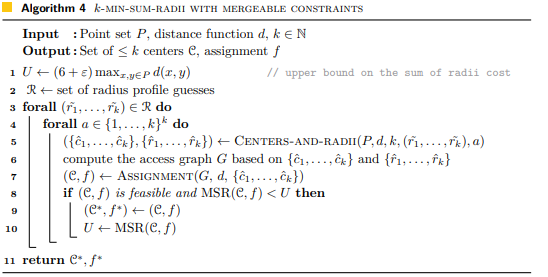

In [16]:
display.Image("img/algorithm4.png")

In [ ]:
# algorithm 4 but without the graph assignment for fairness
def algorithm_4(points, k, dist=pairwise_dist):
    print("Running approximation...")
    final_centers = []
    upper_bound = (2 + 0.5) * max([euclidean(a, b) for a in points for b in points]) # using a 2 + epsilon approximation the sum of all radii can't be larger than 2 + epsilon times the largest distance
    print("Guessing radii...")
    radius_profile_guesses = guessing_radii(points, k)
    print(radius_profile_guesses)
    assignment_tuples = get_assignment_tuples(len(radius_profile_guesses[0]), k)
    print(assignment_tuples)
    final_radii = []
    print("Comparing guesses. This might take a while...")
    for profile in radius_profile_guesses:
        for a in assignment_tuples:
            guessed_centers, radius_profile = algorithm_2(points, k, profile.copy(), a) # .copy() ensures that profile isnt mutated in algorithm_2()
            guessed_solution = (sum(radius_profile)) # need to check if solution is viable
            if (guessed_solution < upper_bound and all_points_covered(guessed_centers, radius_profile, points)):
                final_centers = guessed_centers
                final_radii = radius_profile
                upper_bound = guessed_solution
        print(profile)
    return final_centers, final_radii, upper_bound

NameError: name 'dist' is not defined

In [ ]:
final_centers, final_radii, upper_bound = algorithm_4(points, k)
print("centers:", final_centers)
print("radii:", final_radii)
print("approximation:", upper_bound)

Running approximation...
Guessing radii...
[[np.float64(0.5092308831972221), np.float64(0.7129232364761108), np.float64(0.9980925310665552), np.float64(1.397329543493177), np.float64(1.9485875632546765)], [np.float64(0.7129232364761108), np.float64(0.9980925310665549), np.float64(1.397329543493177), np.float64(1.9562613608904476), np.float64(2.728022588556547)], [np.float64(0.9980925310665552), np.float64(1.3973295434931772), np.float64(1.956261360890448), np.float64(2.738765905246627), np.float64(3.8192316239791655)], [np.float64(1.3973295434931772), np.float64(1.9562613608904478), np.float64(2.738765905246627), np.float64(3.8342722673452774), np.float64(5.346924273570831)], [np.float64(1.956261360890448), np.float64(2.738765905246627), np.float64(3.834272267345278), np.float64(5.367981174283388), np.float64(7.485693982999164)], [np.float64(2.738765905246627), np.float64(3.8342722673452774), np.float64(5.367981174283388), np.float64(7.515173643996743), np.float64(10.479971576198828)],

TypeError: 'sklearn.metrics._dist_metrics.EuclideanDistance64' object is not callable

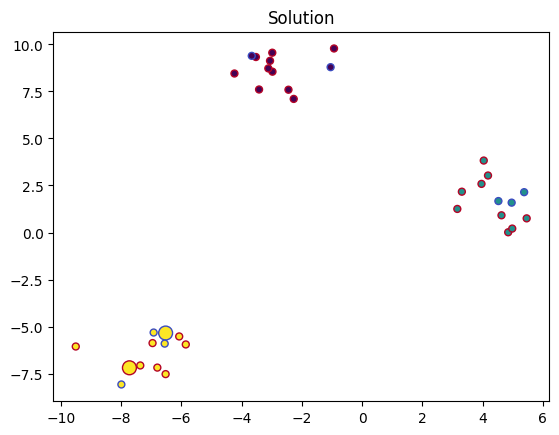

In [ ]:
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=sizes, edgecolor=edge_colors)
plt.show()